# Load data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler,MinMaxScaler,Normalizer,MaxAbsScaler
from sklearn.pipeline import Pipeline
from util import Util
from cost_data_manager import CostDataManager
from matplotlib.backends.backend_pdf import PdfPages

# configuration
############################################################
np.random.seed(1001)
report_directory = "reports" 

excel_file_video = r"video_dataset_with_costs(cost).xlsx"
excel_file_mrs = r"mrs_dataset_with_costs(cost).xlsx"

# set data mode ('mrs' or 'video')
data_mode = "mrs"

if data_mode == "mrs":
    excel_file = excel_file_mrs
elif data_mode == "video":
    excel_file = excel_file_video


cost_labels = [
                'Century Link', 
                'Google', 
                'Azure', 
                'Amazon', 
                'Oracle', 
                'Alibaba', 
                'DigitalOcean'
             ]
used_features = ['Users',
                 'Avg. CPU utilization (%)',
                 #'Max CPU utilization (%)',
                 'NW Egress (GB)',
                 #'Avg RAM (unused, KiB)',
                 'Avg RAM used (MB)',
                 #'Disk write bytes rate',
                 #'Disk read bytes',
                 'Used storage(image size, GB)',
                ] 
outcome_label = 'cost'
############################################################

dataManager = CostDataManager(excel_file, outcome_label, cost_labels, used_features, data_mode=data_mode)
dataManager.load()
dataManager.exportDataset()  

def transformX(X):
    scaler = StandardScaler()
    
    X1 = scaler.fit_transform(X)
    X = pd.DataFrame(X1, columns=X.columns)      
    return X

def transformY(Y):
    return Y
    #data = Y.copy().values
    #data = np.sqrt(data)
    #ret = pd.Series(data)
    #return ret 
def invTrans(X):
    return X

dataManager.setXTransform(transformX)
dataManager.setYTransform(transformY)

m_all = dataManager.getMetrics()
if data_mode == 'mrs':
    m_large = dataManager.getMetricsDBLarge()
    m_xlarge = dataManager.getMetricsDBXLarge()
elif data_mode == 'video':
    m_small = dataManager.getMetricsVideoDBLarge()
    m_medium = dataManager.getMetricsVideoDBMedium()
    m_large = dataManager.getMetricsVideoDBSmall()

working_metrics = m_large
working_metrics_label = "large"
print("Total working data:", len(working_metrics))
util = Util()
util.setInvTrans(invTrans)
working_metrics.head()
X,Y = dataManager.getXY_panda(working_metrics)


0 Century Link
1 Google
2 Azure
3 Amazon
4 Oracle
5 Alibaba
6 DigitalOcean
31 features removed (std +/- 3) -  all
19 features removed (std +/- 3) -  large
18 features removed (std +/- 3) -  xlarge

COST
0        477.283046
1        958.641754
2       1584.025672
3       2394.248713
4       3117.935457
5       3799.544801
6       4471.689168
7       5152.089916
8       5809.187148
9       6528.618718
10      7214.409800
11      7900.173222
12      8599.722910
13      9324.204709
14     10026.027750
15        63.858359
16       293.058074
17       710.518988
18      1166.227835
19      1635.049669
20      2123.963076
21      2635.671259
22      3128.452819
23      3595.232119
24      4087.117767
25      5060.737383
26      6157.993331
27      6649.533711
28      7134.649605
29      7586.085524
           ...     
611      302.903589
612      407.773934
613      534.190059
614      658.503797
615     1367.678863
616     1505.688799
617     1643.333197
618     1643.333197
619     1927.3017

## VIF 

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import cross_validation
metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=0.3, random_state=0)

vif = [variance_inflation_factor(X_train.values, j) for j in range(X_train.shape[1])]
df = pd.DataFrame()
df["feature"] = X_train.columns.values
df["vif"] = vif
df

,feature,vif
0,Users,7.535319
1,Avg. CPU utilization (%),2.725322
2,NW Egress (GB),9.370816
3,Avg RAM used (MB),15.041635
4,"Used storage(image size, GB)",8.287265
5,Century Link,1.581065
6,Google,1.560275
7,Azure,1.563017
8,Amazon,1.532835
9,Oracle,1.626564


# Selected features

In [3]:
X,Y = dataManager.getXY_panda(working_metrics)
print("selected features:")
selected_features_names = X.columns
print(selected_features_names.values)

selected features:
['Users' 'Avg. CPU utilization (%)' 'NW Egress (GB)' 'Avg RAM used (MB)'
 'Used storage(image size, GB)' 'Century Link' 'Google' 'Azure' 'Amazon'
 'Oracle' 'Alibaba']


## Distribution plots

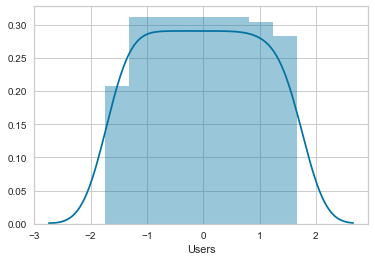

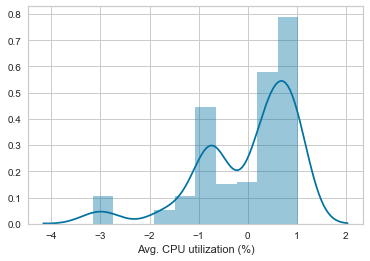

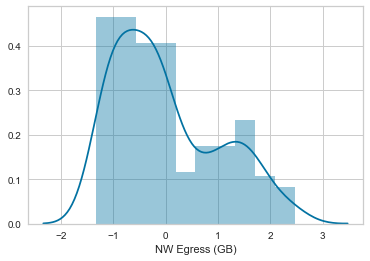

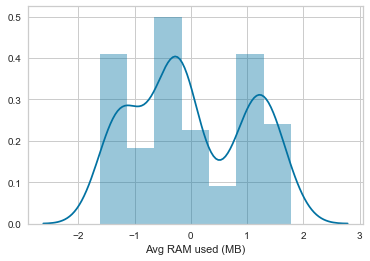

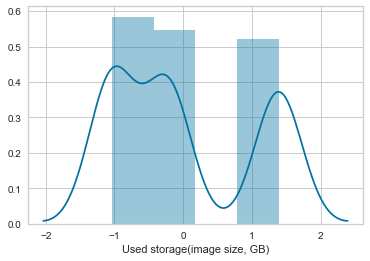

In [4]:
metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)

metrics = working_metrics
for name in used_features:
        sns.distplot(X[name])
        plt.show()


# Regression results report

In [5]:
from sklearn import cross_validation
from sklearn import metrics as m
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

regression_models = dict()

test_size = 0.3

## PCA

In [6]:
# PCA + Linear regression for given number of components
def pcr(X,y,pc):
    # Define the PCA object
    pca = PCA()


    # Run PCA producing the reduced variable Xred and select the first pc components
    Xreg = pca.fit_transform(X)[:,:pc]

    model = LinearRegression()
    model.fit(Xreg, y)

    # Calibration
    y_c = model.predict(Xreg)

    # Cross-validation
    y_cv = cross_val_predict(model, Xreg, y, cv=10)

    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)

    y2, y_c2 = util.inverse_transform(y, y_c, util.inv_trans)
    y2, y_cv2 = util.inverse_transform(y, y_cv, util.inv_trans)

    # Calculate mean square error for calibration and cross validation
    mae_c = mean_absolute_error(y2, y_c2)
    mae_cv = mean_absolute_error(y2, y_cv2)

    return(y_cv, score_c, score_cv, mae_c, mae_cv, model)

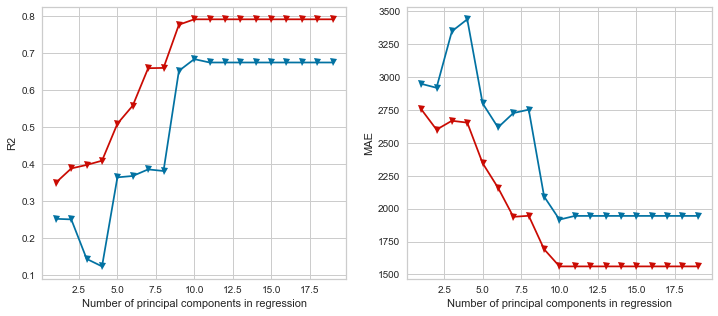

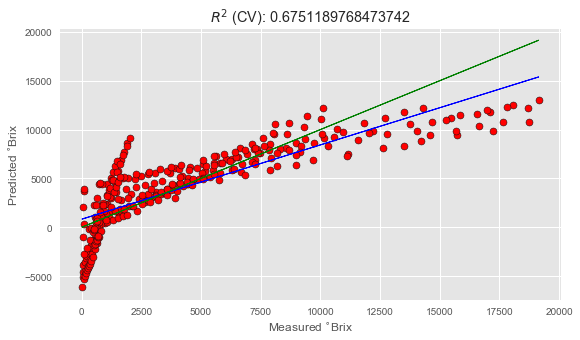

MAE: 1944.738170940921
MSE: 6863468.412658694
MAPE: 462.548194733265
RMSE: 2619.8222101239417
EVS: 0.6777933119941209
AIC: -21.00125049063982
AICc: -20.135676720148016
BIC: 5053.474259959964
R2: 0.6751189768473742
R2(adj): 0.6634019563402302


In [7]:
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter 
from sklearn import linear_model 
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
_r2r = []
_r2cv = []
_mser = []
_mscv = []
_predicted = []
max_r = 20
for i in range(1,max_r):  
    predicted, r2r, r2cv, mser, mscv, model = pcr(X,Y, pc=i)
    _r2r.append(r2r)
    _r2cv.append(r2cv)
    _mser.append(mser)
    _mscv.append(mscv)
    _predicted.append(predicted)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(np.arange(1,max_r), _r2r, '-vr')
ax1.plot(np.arange(1,max_r), _r2cv, '-v')
ax1.set_ylabel('R2')
ax1.set_xlabel('Number of principal components in regression')
ax2.plot(np.arange(1,max_r), _mser, '-vr')
ax2.plot(np.arange(1,max_r), _mscv, '-v')
ax2.set_ylabel('MAE')
ax2.set_xlabel('Number of principal components in regression')
    
# best case
predicted, r2r, r2cv, mser, mscv, model = pcr(X,Y, pc=12)

# Regression plot
# green line -> ideal 100% correlation between measured and predicted
# blue line -> actual correlation
z = np.polyfit(Y, predicted, 1)
with plt.style.context(('ggplot')):
    fig, ax = plt.subplots(figsize=(9, 5))
    ax.scatter(Y, predicted, c='red', edgecolors='k')
    ax.plot(Y, z[1]+z[0]*Y, c='blue', linewidth=1)
    ax.plot(Y, Y, color='green', linewidth=1)
    plt.title('$R^{2}$ (CV): '+str(r2cv))
    plt.xlabel('Measured $^{\circ}$Brix')
    plt.ylabel('Predicted $^{\circ}$Brix')
    plt.show()
    
util.regression_report(Y, predicted,"PCA", X.shape[1])
regression_models["PCA"] = {'model': model,  'X_train': X, 'X_test': X, 'Y_train': Y, 'Y_test': Y, 'predicted': predicted}
    

## MARS

In [8]:
from pyearth import Earth
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor
import eli5
from eli5.sklearn import PermutationImportance

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

model = Earth(max_degree=4, penalty=1.0, minspan_alpha = 0.01, endspan_alpha = 0.01, endspan=5)
model = AdaBoostRegressor(base_estimator=model, n_estimators=20, learning_rate=0.01, loss="exponential")
#model = BaggingRegressor(base_estimator=model, n_estimators=25)

model.fit(X_train,Y_train)

pred = model.predict(X_test)
util.regression_report(Y_test, pred,"MARS", X.shape[1])
regression_models["MARS"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

###Dodano za Permutation importance
###################################
perm = PermutationImportance(model, n_iter=150, random_state=1).fit(X_test, Y_test)
print("")
print("")
print("Eli5.show_weights")
print("=================")
print("")
eli5.show_weights(perm, feature_names = X_test.columns.tolist())
    #print("=================")
    #print("")
###################################


#pred = model.predict(X_test)
#util.regression_report(Y_test, pred,"MARS", X.shape[1])
#regression_models["MARS"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

MAE: 97.47451663578461
MSE: 33735.96719936576
MAPE: 14.01614471016093
RMSE: 183.67353429213955
EVS: 0.9983145021317639
AIC: -7.981336029239603
AICc: -4.838478886382461
BIC: 1051.134533128735
R2: 0.9983139853709908
R2(adj): 0.9980931977410015


Eli5.show_weights



Weight,Feature
1.5928 ± 0.4992,NW Egress (GB)
1.0325 ± 0.3978,Alibaba
0.8977 ± 0.4214,Google
0.6115 ± 0.2494,Amazon
0.2925 ± 0.1074,Azure
0.1564 ± 0.0598,Century Link
0.0013 ± 0.0014,Users
0.0002 ± 0.0002,"Used storage(image size, GB)"
0.0000 ± 0.0001,Avg RAM used (MB)
0.0000 ± 0.0000,Oracle


# Linear regression with polynomial fit

                                               member   linear_coef
9                                              Oracle -7.122233e+12
5                                        Century Link -6.501362e+12
8                                              Amazon -6.282685e+12
7                                               Azure -5.845059e+12
10                                            Alibaba -5.206647e+12
6                                              Google -2.917999e+12
34        NW Egress (GB) Used storage(image size, GB) -1.560852e+03
14                            Users Avg RAM used (MB) -1.349944e+03
13                               Users NW Egress (GB) -9.282522e+02
41                                Avg RAM used (MB)^2 -8.642012e+02
25  Avg. CPU utilization (%) Used storage(image si... -5.413142e+02
0                                               Users -3.595909e+02
23            Avg. CPU utilization (%) NW Egress (GB) -2.583792e+02
49                     Used storage(image size, 

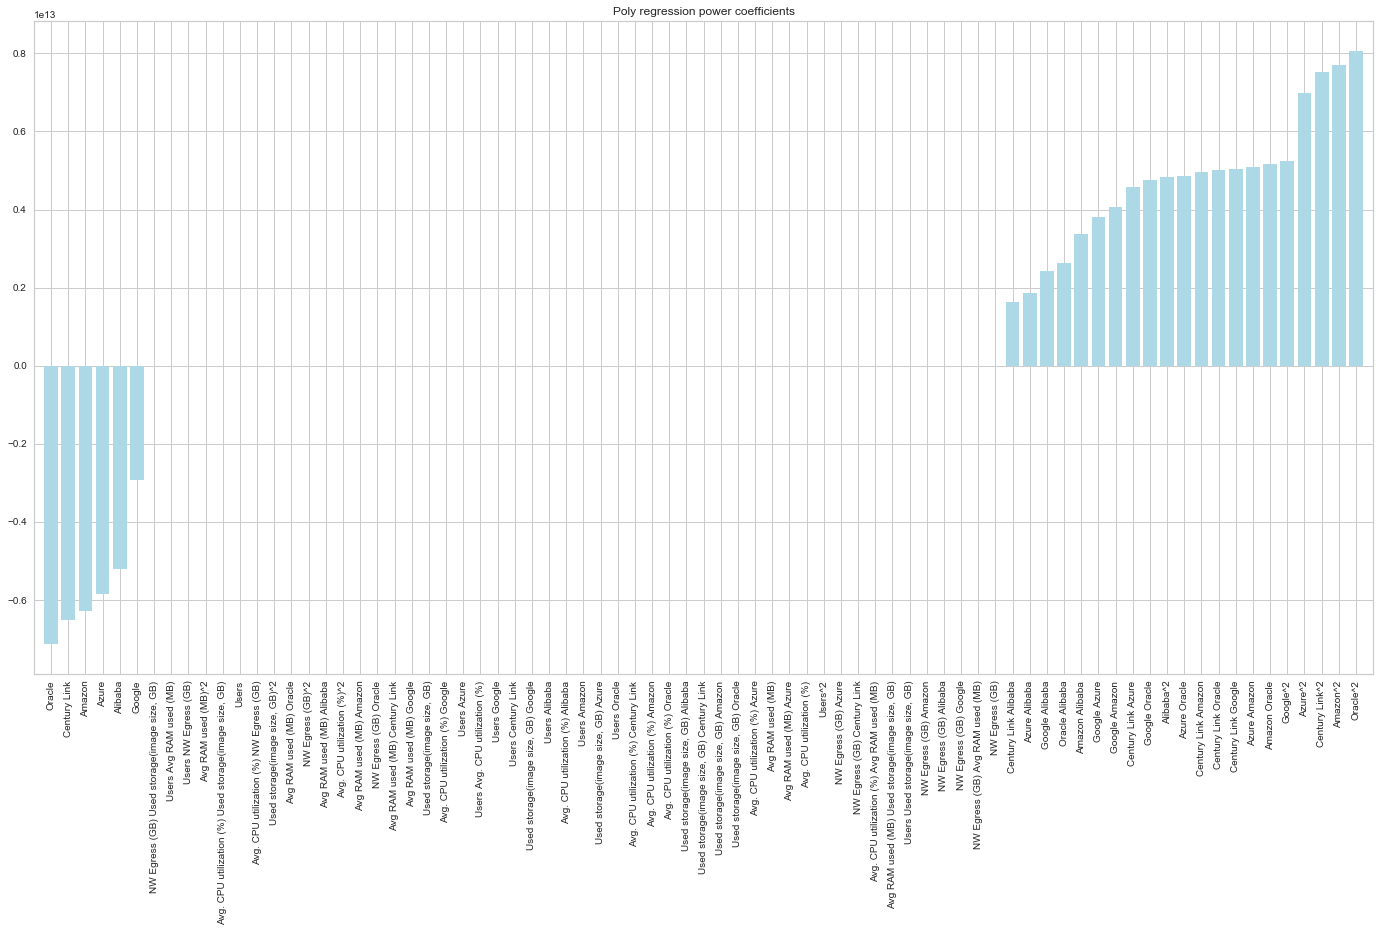

MAE: 193.30508940476543
MSE: 109348.66273980286
MAPE: 65.46312376646598
RMSE: 330.679093291068
EVS: 0.9946045351325314
AIC: -10.333289976647578
AICc: -7.190432833790435
BIC: 1164.0283226043177
R2: 0.9945351071764924
R2(adj): 0.9938194664496045


In [9]:
from sklearn.linear_model import LinearRegression
from pprint import pprint
metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

polynomial_features = PolynomialFeatures(degree=2, include_bias=False)
linear_regression = LinearRegression()
model = Pipeline([("polynomial_features", polynomial_features),
                ("linear_regression", linear_regression)])
model.fit(X_train, Y_train)

r = pd.DataFrame()
r["member"] = polynomial_features.get_feature_names(X.columns)
r["linear_coef"] = linear_regression.coef_
r.sort_values("linear_coef", inplace=True)
pprint(r)

with PdfPages(report_directory + "/cost_" + data_mode + "_" + working_metrics_label + '_poly_power_coeff.pdf') as pdf:
    f, ax = plt.subplots(figsize=(24, 12))
    plt.title('Poly regression power coefficients')
    ax.bar(range(r.shape[0]), r["linear_coef"], color='lightblue', align='center')
    plt.xticks(range(r.shape[0]), r["member"], rotation=90)
    plt.xlim([-1, r.shape[0]])
    plt.show()
    pdf.savefig(f)


true = Y_test
pred = model.predict(X_test)
util.regression_report(true, pred,"Polynomial", X.shape[1])
regression_models["PolyLinearRegression"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

# Lasso Regression

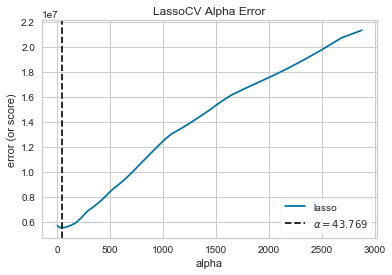

Alpha value before:
43.768686357693745

Alpha value after:
10.800356433741452

MAE: 105.94576621582
MSE: 68650.44043538111
MAPE: 8.867896248338223
RMSE: 262.01229061893474
EVS: 0.9966051636111966
AIC: -9.40226203661613
AICc: -6.259404893758987
BIC: 1119.338981482808
R2: 0.9965690728183968
R2(adj): 0.9961197847350917


In [10]:
from sklearn.linear_model import Lasso, LassoCV
from yellowbrick.regressor import AlphaSelection
import numpy as np

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

polynomial_features = PolynomialFeatures(degree=2)
lasso_reg = LassoCV()
model = Pipeline([("polynomial_features", polynomial_features),
                ("lasso_regression", lasso_reg)])

visualizer = AlphaSelection(lasso_reg)
visualizer.fit(X_train, Y_train)
g = visualizer.poof()

print('Alpha value before:')
print(lasso_reg.alpha_)
print()

model.fit(X_train, Y_train)

print('Alpha value after:')
print(lasso_reg.alpha_)
print()

#visualizer = AlphaSelection(lasso_reg)
#visualizer.fit(X_train, Y_train)
#g = visualizer.poof()

# make predictions on the testing set
pred = model.predict(X_test)
true = Y_test

util.regression_report(true, pred, "Lasso", X.shape[1])
regression_models["Lasso Regression"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}


# Lasso Lars

In [11]:
from sklearn.linear_model import LassoLarsCV

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

polynomial_features = PolynomialFeatures(degree=3, include_bias=False)
lasso_lars_reg = LassoLarsCV()
model = Pipeline([("polynomial_features", polynomial_features),
                ("lasso_lars_regression", lasso_lars_reg)])

model.fit(X_train, Y_train)
pred = model.predict(X_test)
true = Y_test
print(pred[:5])
print(true.values[:5])
util.regression_report(true, pred,"LassoLars", X.shape[1])
regression_models["LassoLars"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

print()
print('Alpha value:')
print(lasso_reg.alpha_)

###Dodano za Permutation importance
###################################
perm = PermutationImportance(model, n_iter=150, random_state=1).fit(X_test, Y_test)
print("")
print("")
print("Eli5.show_weights")
print("=================")
print("")
eli5.show_weights(perm, feature_names = X_test.columns.tolist())
    #print("=================")
    #print("")
###################################

[ 4536.58123679 13375.0708124  15344.13470394   109.56302941
   379.34300913]
[ 4924.34116678 13515.93732726 15452.50959381    80.34823897
   347.95867672]
MAE: 104.70191671344497
MSE: 46820.34832422598
MAPE: 6.293113352485867
RMSE: 216.38010149786413
EVS: 0.9976666460364193
AIC: -8.63684274426214
AICc: -5.493985601404997
BIC: 1082.5988554498165
R2: 0.9976600702821576
R2(adj): 0.9973536509143449

Alpha value:
10.800356433741452


Eli5.show_weights



Weight,Feature
4.2684 ± 3.8078,Alibaba
3.5176 ± 1.7435,Amazon
3.1996 ± 3.8335,Google
1.5069 ± 0.4814,NW Egress (GB)
1.0945 ± 0.5655,Azure
0.8105 ± 0.4191,Century Link
0.0015 ± 0.0011,Users
0.0012 ± 0.0007,Avg RAM used (MB)
0.0006 ± 0.0006,"Used storage(image size, GB)"
0.0001 ± 0.0003,Avg. CPU utilization (%)


##  Ridge Regression

In [12]:
from sklearn.linear_model import RidgeCV

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

polynomial_features = PolynomialFeatures(degree=3, include_bias=False)
ridge = RidgeCV()
model = Pipeline([("polynomial_features", polynomial_features),
                ("ridge_regression", ridge)])

model.fit(X_train, Y_train)

pred = model.predict(X_test)
true = Y_test

util.regression_report(true, pred, "Ridge", X.shape[1])
regression_models["Ridge"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

MAE: 184.71049328594563
MSE: 96392.50191756066
MAPE: 47.62691171922297
RMSE: 310.47141884167155
EVS: 0.9955503021435195
AIC: -10.08106377620642
AICc: -6.938206633349278
BIC: 1151.9214649831424
R2: 0.9951826142289212
R2(adj): 0.9945517660922323


# ElasticNet Regression

In [13]:
from sklearn.linear_model import ElasticNetCV

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

polynomial_features = PolynomialFeatures(degree=3, include_bias=False)
enet = ElasticNetCV(random_state=0)
model = Pipeline([("polynomial_features", polynomial_features),
                ("enet_regression", enet)])

model.fit(X_train, Y_train)

pred = model.predict(X_test)
true = Y_test

util.regression_report(true, pred,"ElasticNet", X.shape[1])
regression_models["ElasticNet Regression"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

MAE: 1058.4503832473176
MSE: 2071463.3184091009
MAPE: 114.06054046919934
RMSE: 1439.2579054530502
EVS: 0.8989821752924594
AIC: -16.216228048134063
AICc: -13.07337090527692
BIC: 1446.409350035669
R2: 0.8964749569012099
R2(adj): 0.8829181060192255


## ExtraTrees Regressor

In [14]:
from sklearn.ensemble import ExtraTreesRegressor

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

model = ExtraTreesRegressor(n_estimators=20, random_state=0)
model.fit(X_train, Y_train)

pred = model.predict(X_test)
true = Y_test

util.regression_report(true, pred, "ExtraTrees Regressor", X.shape[1])
regression_models["ExtraTrees Regressor"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

MAE: 211.66381690007606
MSE: 107098.76724465836
MAPE: 25.828002149791757
RMSE: 327.25947999203686
EVS: 0.9946739422212425
AIC: -10.291709875033561
AICc: -7.148852732176419
BIC: 1162.0324777268452
R2: 0.9946475496832134
R2(adj): 0.9939466335703009


## Random Forest Regressor

In [15]:
from sklearn.ensemble import RandomForestRegressor

metrics = working_metrics
X,Y = dataManager.getXY_panda(metrics)
X_train, X_test, Y_train, Y_test = cross_validation.train_test_split(X, Y, test_size=test_size, random_state=0)

model = RandomForestRegressor(n_estimators=20, random_state=0)
model.fit(X_train, Y_train)

pred = model.predict(X_test)
true = Y_test

util.regression_report(true, pred,"Random Forest", X.shape[1])
regression_models["Random Forest"] = {'model': model,  'X_train': X_train, 'X_test': X_test, 'Y_train': Y_train, 'Y_test': Y_test, 'predicted': pred}

MAE: 343.7351548705919
MSE: 232464.02894458934
MAPE: 28.78577937871267
RMSE: 482.1452363599472
EVS: 0.9898538137401758
AIC: -11.841677938582173
AICc: -8.69882079572503
BIC: 1236.4309447771782
R2: 0.9883821989983922
R2(adj): 0.9868608202958007


# Report

In [16]:
util.regression_results.reset_index(drop=True, inplace=True)
util.get_aic_bic()
print(util.regression_results)

           MAE           MSE        MAPE         RMSE       EVS        AIC  \
0  1944.738171  6.863468e+06  462.548195  2619.822210  0.677793 -21.001250   
1    97.474517  3.373597e+04   14.016145   183.673534  0.998315  -7.981336   
2   193.305089  1.093487e+05   65.463124   330.679093  0.994605 -10.333290   
3   105.945766  6.865044e+04    8.867896   262.012291  0.996605  -9.402262   
4   104.701917  4.682035e+04    6.293113   216.380101  0.997667  -8.636843   
5   184.710493  9.639250e+04   47.626912   310.471419  0.995550 -10.081064   
6  1058.450383  2.071463e+06  114.060540  1439.257905  0.898982 -16.216228   
7   211.663817  1.070988e+05   25.828002   327.259480  0.994674 -10.291710   
8   343.735155  2.324640e+05   28.785779   482.145236  0.989854 -11.841678   

        AICc          BIC        R2   R2(adj)  AIC delta    BIC delta  \
0 -20.135677  5053.474260  0.675119  0.663402  13.019914  4002.339727   
1  -4.838479  1051.134533  0.998314  0.998093   0.000000     0.000000   


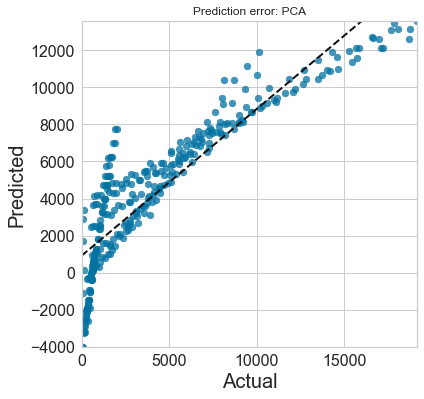

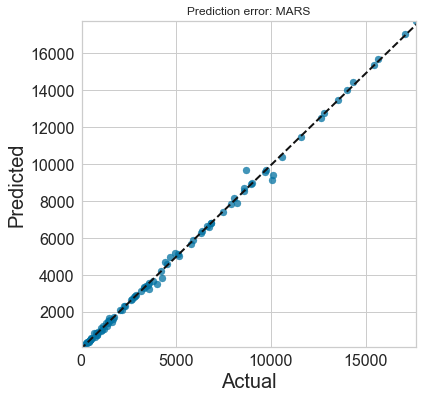

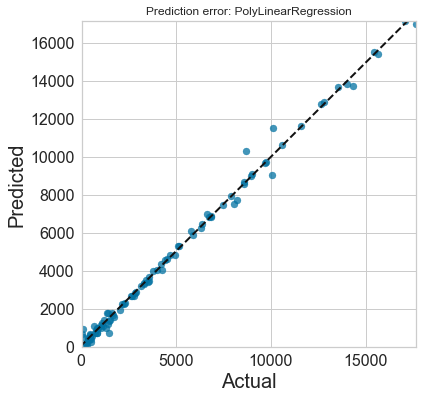

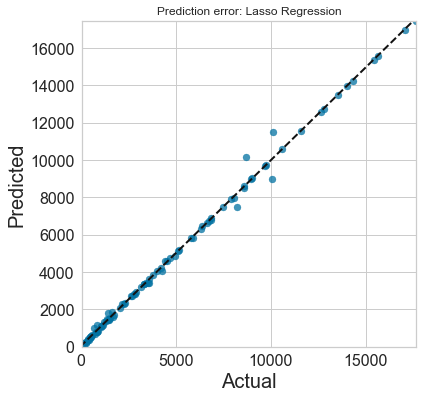

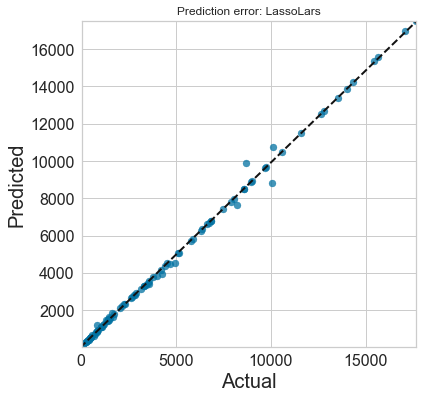

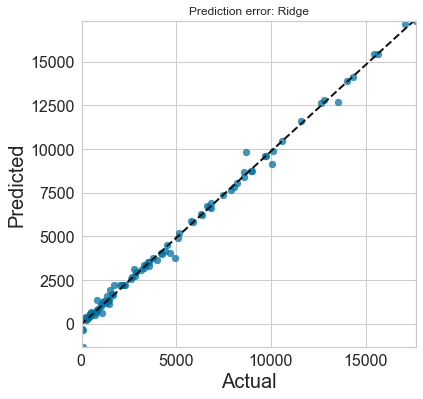

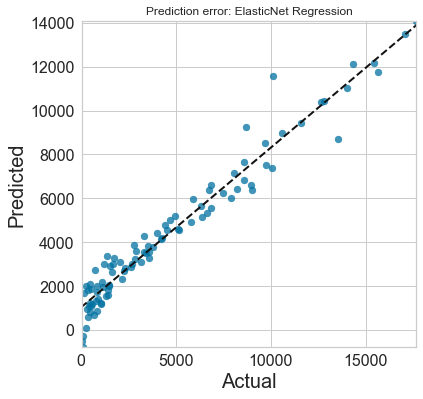

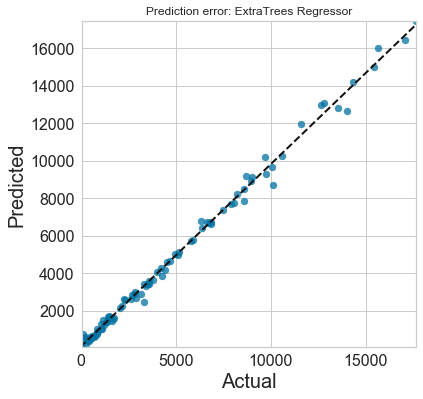

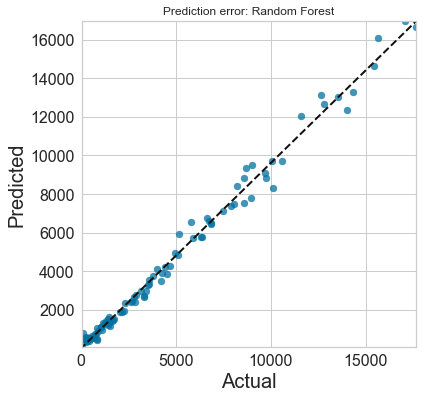

In [17]:
with PdfPages(report_directory + "/cost_" + data_mode + '_graphs_prediction_error_test.pdf') as pdf:
    for model_info_label in regression_models:
        f, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlabel('Actual', fontsize=20)
        ax.set_ylabel('Predicted', fontsize=20)
        ax.tick_params(axis='both', which='major',labelsize=16)
        ax.tick_params(axis='both', which='minor',labelsize=16)
        #ax.legend().set_visible(False)
        #ax.legend().remove()
        util.visualize_prediction_error(regression_models[model_info_label])
        ax.legend().set_visible(False)
        ax.set_title('Prediction error: ' + model_info_label)
        
        pdf.savefig(f, bbox_inches='tight')
        #util.visualize_residuals_plot(regression_models[model_info_label])
        #pdf.savefig(f)


# Residuals graphs

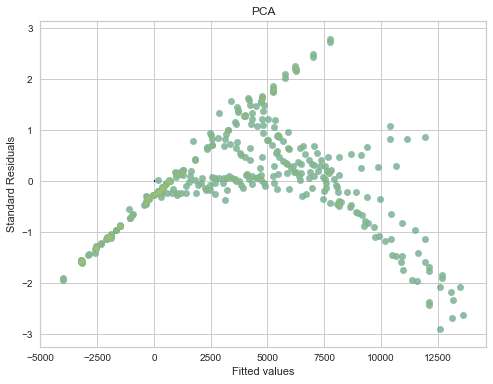

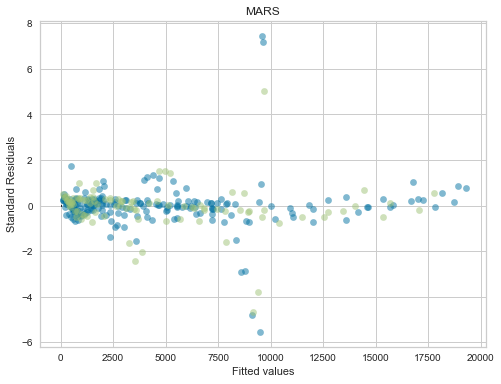

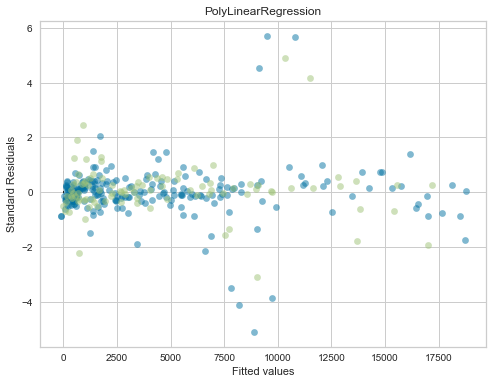

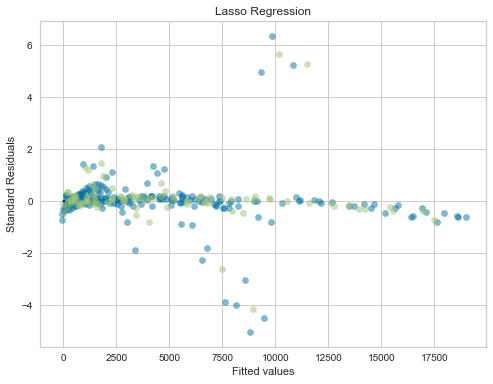

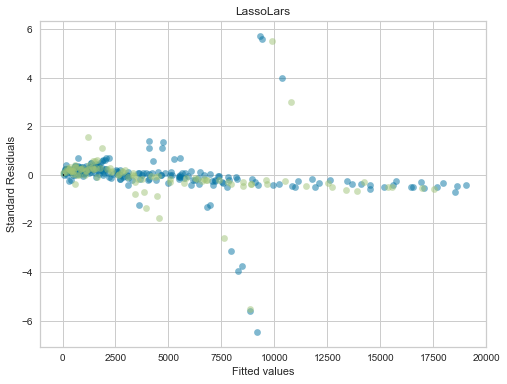

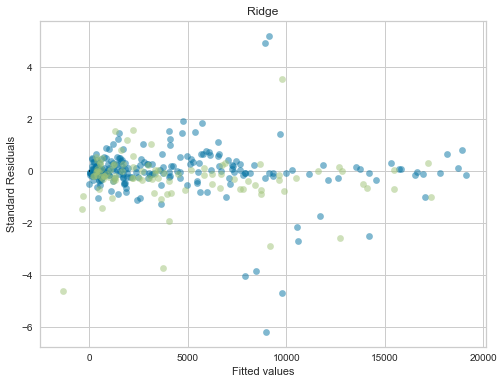

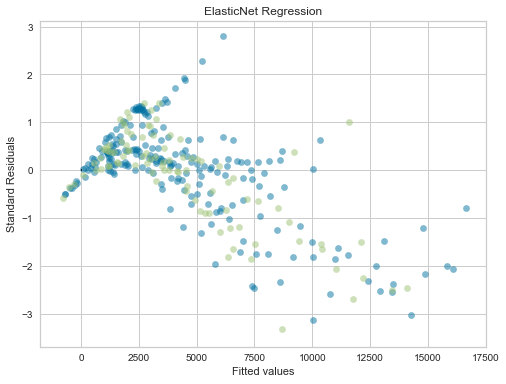

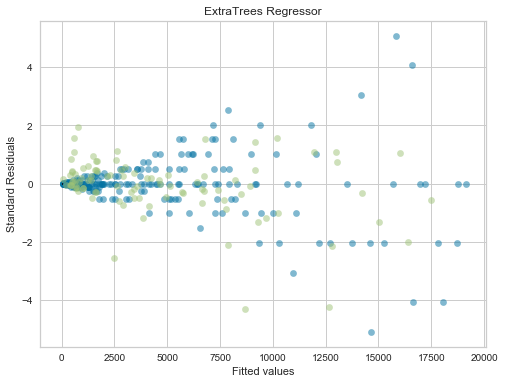

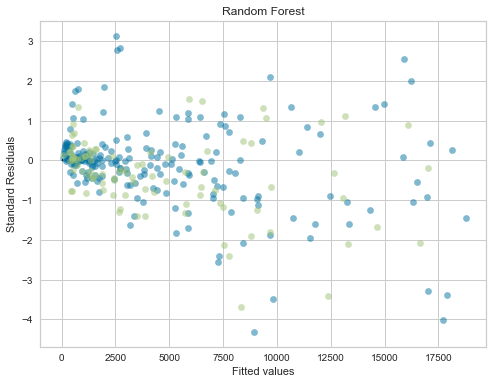

In [18]:
with PdfPages(report_directory + "/cost_" + data_mode + '_graphs_residuals.pdf') as pdf:
    for model_info_label in regression_models:
        f, ax = plt.subplots(figsize=(8, 6))
        util.residuals_graph(regression_models[model_info_label], model_info_label)
        pdf.savefig(f)

# Prediction graphs

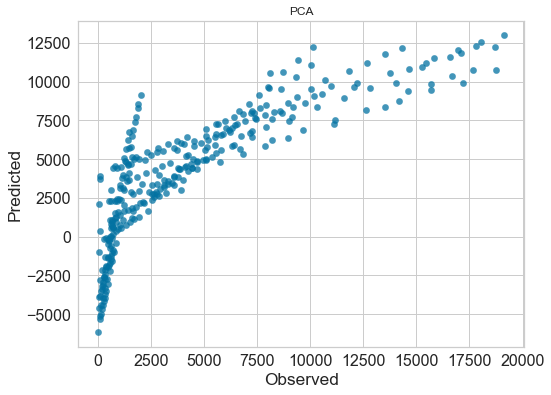

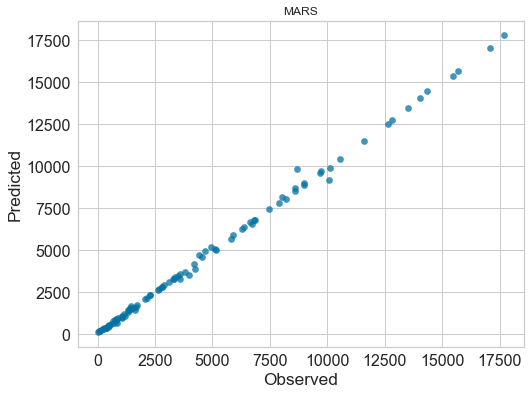

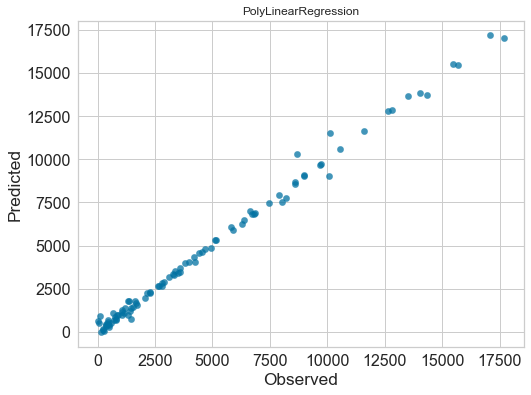

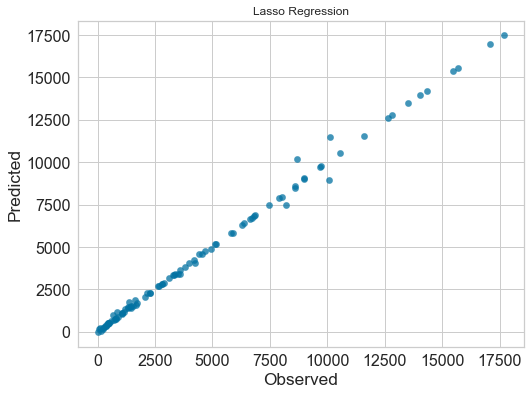

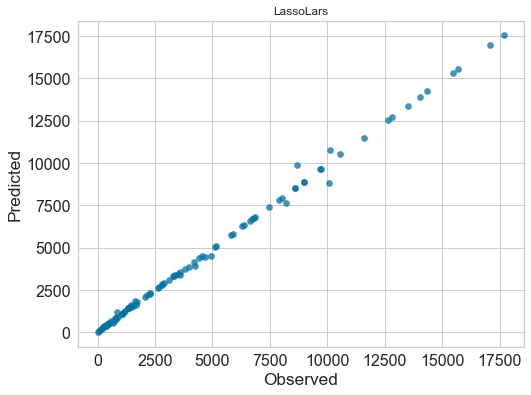

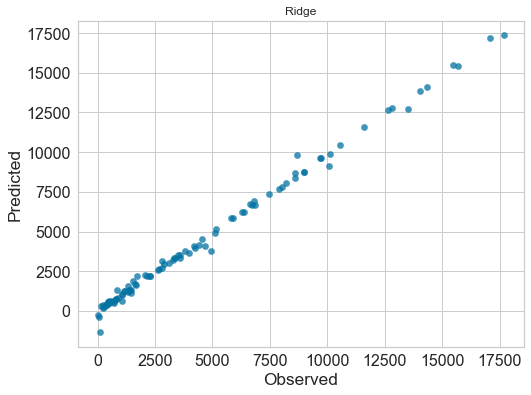

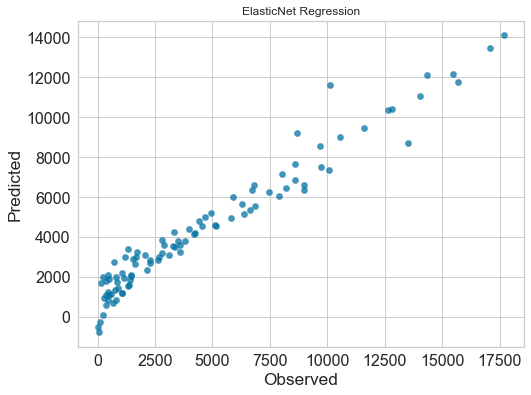

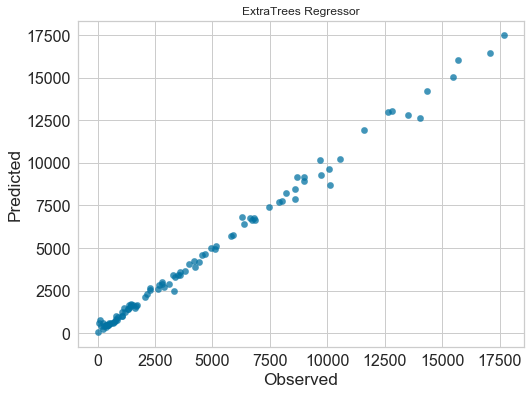

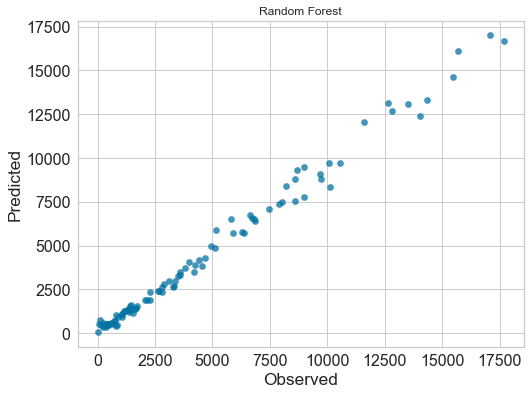

In [19]:
with PdfPages(report_directory + "/cost_" + data_mode + '_graphs_prediction.pdf') as pdf:
    for model_info_label in regression_models:
        f, ax = plt.subplots(figsize=(8, 6))
        util.pred_true_graph(regression_models[model_info_label], model_info_label)
        pdf.savefig(f)

# QQ graphs

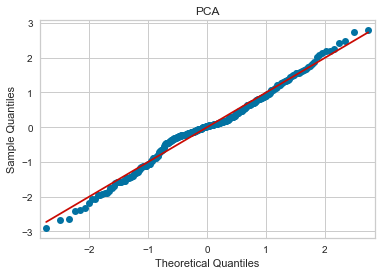

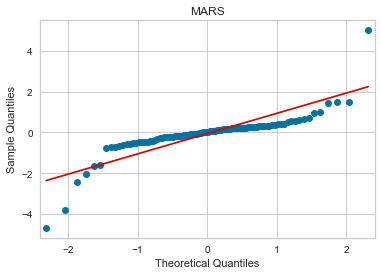

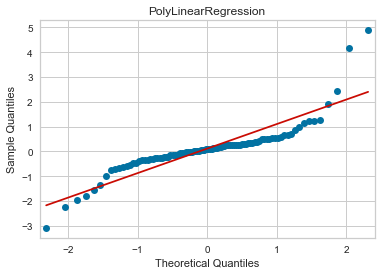

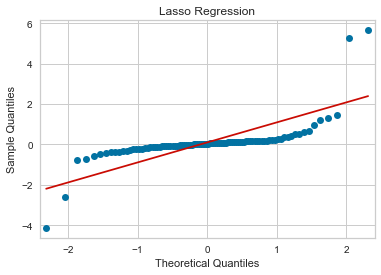

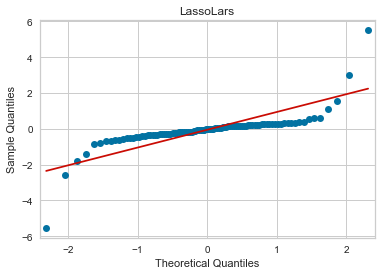

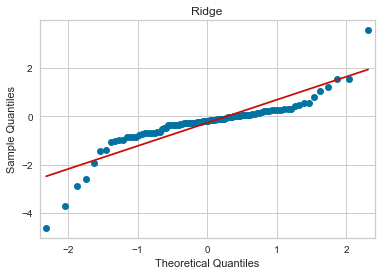

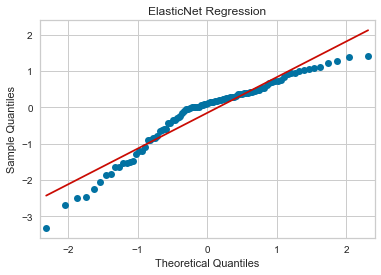

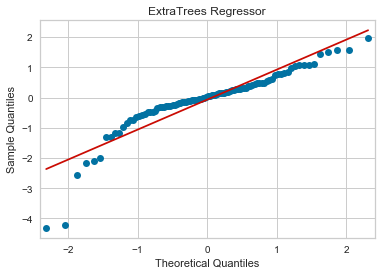

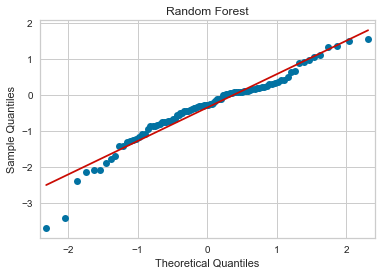

In [20]:
with PdfPages(report_directory + "/cost_" + data_mode + '_graphs_qq.pdf') as pdf:
    for model_info_label in regression_models:
        util.qq_graph(regression_models[model_info_label], model_info_label, pdf)

# Scale location graphs

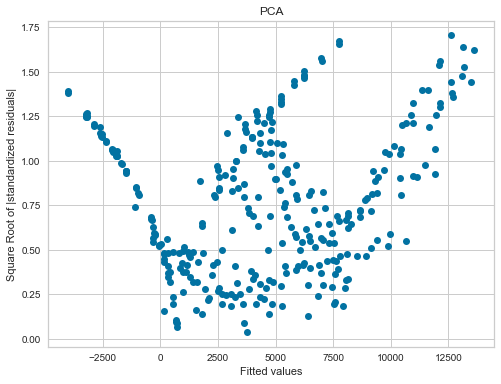

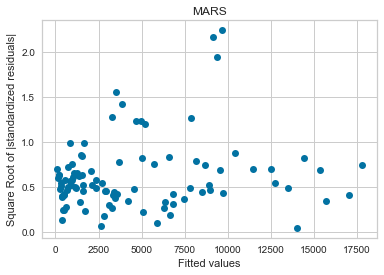

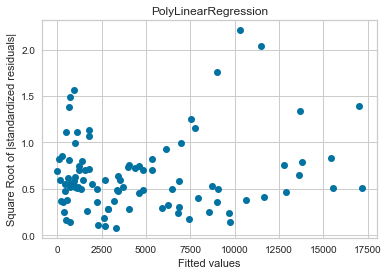

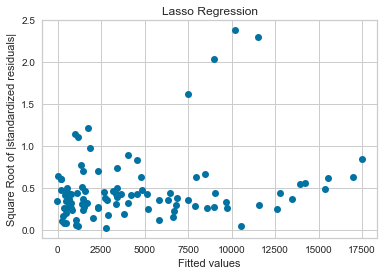

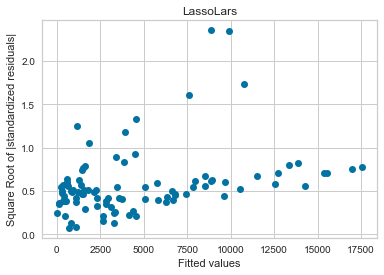

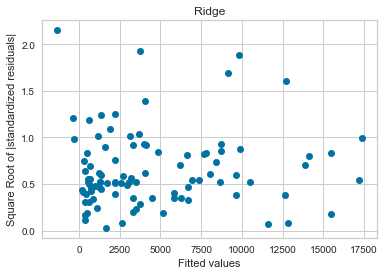

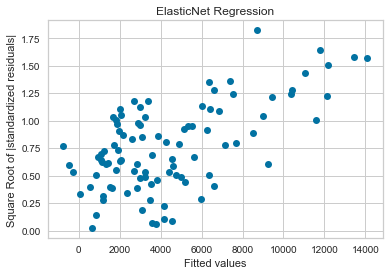

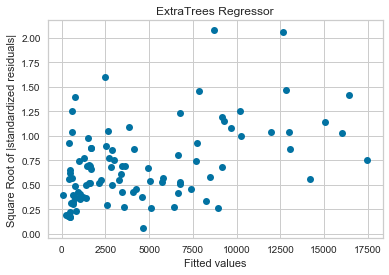

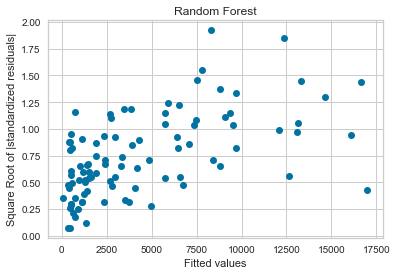

In [21]:
with PdfPages(report_directory + "/cost_" + data_mode + '_graphs_scale_location.pdf') as pdf:
    f, ax = plt.subplots(figsize=(8, 6))
    for model_info_label in regression_models:
        util.scale_location_graph(regression_models[model_info_label], model_info_label)
        pdf.savefig(f)